In [ ]:
"""Implementation of Monte Carlo Dropout, the results are fused into results dataset

In [3]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nibabel
import nibabel.processing
import os
from skimage.filters import threshold_otsu
import cc3d
import shutil
import pickle
import keras_tuner as kt
import random
from scipy import ndimage
from tqdm.notebook import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm, trange
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [5]:
#USE SMALL GPU#
use_gpu = 1
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

In [ ]:
#Custom MC Dropout layer

In [6]:
class MCDropout(tf.keras.layers.Dropout):
    def call (self, inputs):
        return super().call(inputs, training=True)

In [7]:
#Borrowed from the 3D preprocessing

def normalize(volume):
    """Normalize the volume"""
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def pp(original_image):
    
    input_img=input_img = nibabel.load("{0}".format(original_image))
    resampled_img = nibabel.processing.conform(input_img, out_shape=(100,100,90), voxel_size=(2.0, 2.0, 2.0))
    
    img = resampled_img.get_fdata()
    
    thresh = threshold_otsu(img)
    bw_img1 = np.copy(img)
    bw_img1[bw_img1 < thresh] = 0
    bw_img1[bw_img1 >= thresh] = 255
    
    input_CCA=bw_img1.astype('int32')
    connectivity = 6
    labels_out, N = cc3d.connected_components(input_CCA, return_N=True)
    
    def mask_largest_label (labels_out, N):
        #print("This function returns the largest blob of a CCA processed image as a binary mask")
        #print("")
        def separate_labels(label_ID, label_matrix):
            mask=1*(label_matrix == label_ID)
            return mask
        labellist=[]
        for j in range(1, N+1):
            a=separate_labels(j, labels_out)
            labellist.append(a)
        #print("The image has {0} labels".format(len(labellist)))
        z=labellist[0]
        #print("The shape of the labels is: {0}".format(z.shape))
        sizelist=[]
        for counter,element in enumerate (labellist):
            a=labellist[counter].sum()
            sizelist.append(a)
        #print("Label sizes: {0}".format(sizelist))
        sizelist=np.asarray(sizelist)
        a=sizelist.argmax()
        #print("The largest label index is: {0}".format(a))
        mask=labellist[a]
        #print("The largest label is now a binary mask with shape {0}, size {1}, max value {2} and min value {3}".format((mask.shape),(mask.sum()),(mask.max()),(mask.min())))
        return mask

    mask=mask_largest_label(labels_out, N)
    
    pimg=np.multiply(img,mask)
    
    return pimg

def process(path):
    """Read and normalize volume"""
    # Read and pp scan
    volume = pp(path)
    # Normalize
    volume = normalize(volume)
    #Prepare for NN input
    volume = np.expand_dims(volume, axis=0)
    volume = np.expand_dims(volume, axis=4)
    return volume

In [ ]:
#This is where I swap the last Dropout layer, which is number 19 in the model (see figure) for the MCD layer

In [8]:
def get_montecarlo(modeldir):
    model=tf.keras.models.load_model(modeldir)
    x=model.layers[18].output
    x=MCDropout(0.4)(x)
    x=model.layers[20](x)
    x=model.layers[21](x)
    predictions=model.layers[22](x)
    
    montecarlo = tf.keras.Model(inputs=model.inputs,outputs=predictions)
    return montecarlo

In [ ]:
"""This function takes the 5 models (one trained in each fold) and makes MCD predictions for each one, 500 iterations
Each model makes predictions in their own 20% holdout validation. At the end we build a dataset concatenating all 
predictions for each of those 20%s, getting to the full dataset. Each patient has an SD value and a MC_ensemble
value, which is the MCD preciction that has been described to outperform "regular" predictions and MC mean 
predictions.

Besides, it returns the whole MC accuracies.

In [15]:
def get_preds_mc(models,directories, groundts):
    
    montecarlo_mean_accs=[]
    ds=0
    allaccs=[]
    for n in range(len(models)):
        model=get_montecarlo(models[n])
        dire=directories[n]
        groundt=groundts[n]
        
        subjects=os.listdir(dire)
        
        groundl=[]
        for i in os.listdir(dire):
                if i in os.listdir(groundt):
                    groundl.append(1)
                else:
                    groundl.append(0)
    
        mc_predictions = []
        for i in tqdm(range(500),desc='MonteCarlo for fold {}'.format(n)):
            y_p=[]
            for i in os.listdir(dire):
                volume=process(os.path.join(dire,'{}'.format(i)))
                prediction=model.predict(volume)
                y_p.append(prediction[0][0])
            mc_predictions.append(y_p)
        
        accs=[]
        for y_p in mc_predictions:
            acc = accuracy_score(groundl,(1*np.asarray(tf.greater(y_p, 0.5))) )
            accs.append(acc)
        meanacc=sum(accs)/len(accs)
        montecarlo_mean_accs.append(meanacc)
        allaccs.append(accs)
        
        mc_ensemble_pred = np.array(mc_predictions).mean(axis=0)
        
        sd=np.array(mc_predictions).std(axis=0)
        
        mc_ensemble_pred=list(mc_ensemble_pred)
        sd=list(sd)
        
        if n==0:
            ds=pd.DataFrame(list(zip(groundl, mc_ensemble_pred,sd)),columns =['GT', 'MC_pred', 'SD'],index=subjects)
        else:
            d=pd.DataFrame(list(zip(groundl, mc_ensemble_pred,sd)),columns =['GT', 'MC_pred', 'SD'],index=subjects)
            ds=pd.concat((ds,d),axis=0)

    return montecarlo_mean_accs, ds, allaccs

In [13]:
models= ["/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn0/epoch16/",
        "/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn1/epoch19",
        "/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn2/epoch17",
        "/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn3/epoch22",
        "/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn4/epoch9"]
directories=["/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/whole",
            "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/whole",
            "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/whole",
            "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/whole",
            "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/whole"]
groundts=["/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/pMCI",
         "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/pMCI",
          "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/pMCI",
          "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/pMCI",
          "/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/pMCI"]
        

In [16]:
mean_accs,ds,allaccs=get_preds_mc(models,directories,groundts)

MonteCarlo for fold 0:   0%|          | 0/500 [00:00<?, ?it/s]

MonteCarlo for fold 1:   0%|          | 0/500 [00:00<?, ?it/s]

MonteCarlo for fold 2:   0%|          | 0/500 [00:00<?, ?it/s]

MonteCarlo for fold 3:   0%|          | 0/500 [00:00<?, ?it/s]

MonteCarlo for fold 4:   0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
np.asarray(mean_accs).mean()

0.786237908037908

In [18]:
alac=np.asarray(allaccs).flatten()

In [35]:
np.savetxt("mean_accs.csv", mean_accs, delimiter=",")

In [37]:
np.savetxt("allaccs.csv", allaccs, delimiter=",")

In [1]:
plt.hist(alac, bins=10,color='y')
plt.axvline(x=sum(mean_accs)/len(mean_accs), color="r")
plt.axvline(x=accuracy_score(ds['GT'], (1*np.asarray(tf.greater(ds['MC_pred'], 0.5)))),color='g', label='MonteCarlo ensemble accuracy')

NameError: name 'plt' is not defined

Area under ROC curve is:  0.8276800226132429


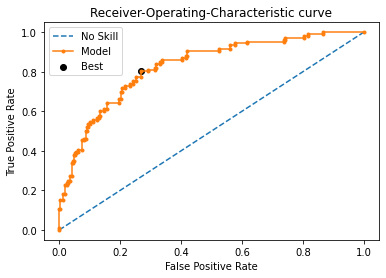

S-E Best Threshold=0.308776, G-Mean=0.765
Accuracy:  0.7479892761394102
Sensitivity:  0.7924528301886793
Specificity:  0.7303370786516854
PPV:  0.5384615384615384
NPV:  0.8986175115207373


In [25]:
auc=roc_auc_score(ds['GT'],ds['MC_pred'])
print("Area under ROC curve is: ",auc)
fpr, tpr, thresholds = roc_curve(ds['GT'],ds['MC_pred'], drop_intermediate=True)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Model')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.title("Receiver-Operating-Characteristic curve")
pyplot.show()
print('S-E Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print("Accuracy: ",accuracy_score(ds['GT'], (1*np.asarray(tf.greater(ds['MC_pred'], 0.308776)))))
tn, fp, fn, tp = confusion_matrix(ds['GT'], (1*np.asarray(tf.greater(ds['MC_pred'], 0.308776)))).ravel()
sens=tp/(tp+fn)
print("Sensitivity: ",sens)
spec=tn/(fp+tn)
print("Specificity: ", spec)
tpv=tp/(tp+fp)
print("PPV: ", tpv)
fpv=tn/(fn+tn)
print("NPV: ", fpv)

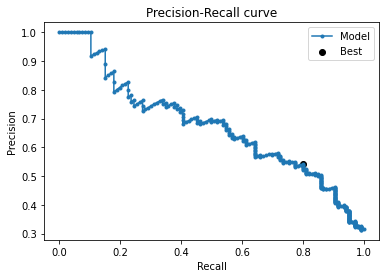

S-TPV Best Threshold=0.308776, F-Score=0.646


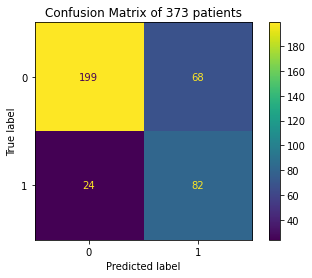

In [21]:
# calculate pr curves
precision, recall, thresholds = precision_recall_curve(ds['GT'],ds['MC_pred'])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
# plot the pr curve for the model
pyplot.plot(recall, precision, marker='.', label='Model')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.title("Precision-Recall curve")
pyplot.show()
print('S-TPV Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

cm = confusion_matrix(ds['GT'], (1*np.asarray(tf.greater(ds['MC_pred'], 0.314664))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
pyplot.title("Confusion Matrix of {} patients".format(len(ds.index)))
pyplot.show()

In [22]:
pwd

'/local_mount/space/celer/1/users/notebooks/moises'

In [ ]:
#Here we export it to excel, which would then be loaded into results

In [23]:
ds.to_excel('mc_preds_SD500.xlsx')

ds

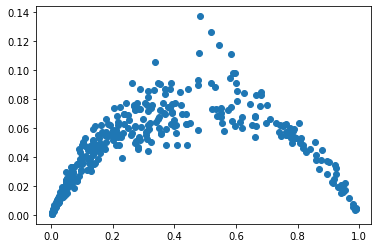

In [26]:
plt.scatter(ds['MC_pred'],ds['SD'])

In [29]:
from scipy.stats import gaussian_kde

In [27]:
x=ds['MC_pred']
y=ds['SD']

In [30]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

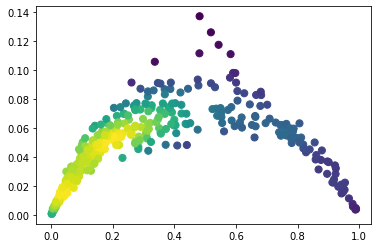

In [31]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()